In [3]:
import pandas as pd
import numpy as np
import xgboost
import seaborn as sns

import matplotlib.pyplot as plt

import plotly

In [4]:
df = pd.read_csv("precontrast_pyradiomics.csv")
df

,patient,sequence,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,ER,PR,HER2,Mol Subtype
0,Breast_MRI_001,pre,0.891808,0.850437,29.186299,34.319179,38.431136,36.073737,39.309346,46.240422,...,8.618192e+07,5.497338,0.091060,0.000782,3.011166e-07,0.092604,0,0,1,2
1,Breast_MRI_002,pre,0.668996,0.650923,18.931009,29.083312,29.852205,23.148662,29.748492,33.784677,...,2.374784e+06,288.409155,0.001006,0.127011,1.063641e-02,0.001006,0,0,0,3
2,Breast_MRI_003,pre,0.934408,0.286810,13.808210,48.144081,43.126056,40.488107,56.606869,57.665740,...,1.041128e+08,1140.457544,0.000980,0.048920,7.407411e-03,0.000972,1,1,0,0
3,Breast_MRI_004,pre,0.707826,0.609522,8.893590,14.591090,14.972284,11.420813,14.477716,16.540987,...,9.257838e+04,13.834676,0.018998,0.059076,1.871148e-03,0.018887,1,1,0,0
4,Breast_MRI_005,pre,0.679296,0.424353,22.534695,53.103672,49.674566,55.175581,36.443449,58.274413,...,5.935692e+06,1166.081998,0.000341,0.127535,2.374788e-02,0.000341,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,Breast_MRI_918,pre,0.877153,0.648783,29.186299,44.986213,41.977361,45.886501,51.383808,56.811793,...,2.595984e+07,347.559346,0.000763,0.039988,1.473374e-03,0.000761,1,1,0,0
918,Breast_MRI_919,pre,0.964239,0.648439,13.914028,21.457727,21.084250,21.631462,25.375225,27.677709,...,1.102838e+07,4.555260,0.110201,0.002182,3.016729e-06,0.105313,1,1,0,0
919,Breast_MRI_920,pre,0.877183,0.856791,15.749673,18.382163,20.649190,19.038279,20.505122,24.348411,...,0.000000e+00,0.000000,1000000.000000,0.000000,0.000000e+00,0.000000,1,1,0,0
920,Breast_MRI_921,pre,0.913000,0.800835,33.226543,41.489900,45.448460,43.076382,48.143552,55.603011,...,1.360858e+07,6049.519483,0.000420,0.102645,2.014567e-02,0.000420,1,1,0,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [6]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

SEED = 2454259

In [7]:
def train_test_val_splits(df, train_ratio = 0.8, val_ratio = 0.2, random_state = 2454259):
   
    val_ratio_adj = val_ratio / (1-train_ratio)

    train_df, val_df = train_test_split(df, train_size = train_ratio, random_state= random_state)
    val_df, test_df = train_test_split(val_df, train_size = val_ratio_adj, random_state= random_state)

    print(len(train_df))

    return train_df, val_df, test_df


In [8]:
train_df, val_df, test_df = train_test_val_splits(df.drop(columns = ['sequence', 'patient']), TRAIN_RATIO, VAL_RATIO, random_state = SEED)
len(train_df), len(val_df), len(test_df)

553


(553, 184, 185)

In [9]:
train_x, train_y, train_y_subtype = train_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype']), train_df[['ER', 'PR', 'HER2', 'Mol Subtype']], train_df['Mol Subtype']
val_x, val_y, val_y_subtype = val_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype']), val_df[['ER', 'PR', 'HER2', 'Mol Subtype']], val_df['Mol Subtype']
test_x, test_y, test_y_subtype = test_df.drop(columns = ['ER', 'PR', 'HER2', 'Mol Subtype']), test_df[['ER', 'PR', 'HER2', 'Mol Subtype']], test_df['Mol Subtype']

## Feature Importance

In [10]:
def get_feature_importances(FEATURE, LIMIT, train_x, train_y, val_x, val_y, test_x, test_y):

    xgb_predictor = DecisionTreeClassifier(criterion = 'gini')
    xgb_predictor.fit(train_x, train_y[FEATURE])
    

    preds = xgb_predictor.predict(train_x)
    preds_val = xgb_predictor.predict(val_x)
    preds_test = xgb_predictor.predict(test_x)

    print("Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(accuracy_score(train_y[FEATURE], preds), accuracy_score(val_y[FEATURE], preds_val)))
    print("Training Precision: {:.4f}, Validation Precision: {:.4f}".format(precision_score(train_y[FEATURE], preds, average = 'weighted'), precision_score(val_y[FEATURE], preds_val, average = 'weighted')))
    print("Training Recall: {:.4f}, Validation Recall: {:.4f}".format(recall_score(train_y[FEATURE], preds, average = 'weighted'), recall_score(val_y[FEATURE], preds_val, average = 'weighted')))
    print("Training F1-Score: {:.4f}, Validation F1-Score: {:.4f}".format(f1_score(train_y[FEATURE], preds, average = 'weighted'), f1_score(val_y[FEATURE], preds_val, average = 'weighted')))

    target_names = ['{} negative'.format(FEATURE), '{} positive'.format(FEATURE)]
    if(FEATURE == 'Mol Subtype'):
        target_names = ['Luminal-like', 'ER/PR Pos, HER2 Pos', 'HER2', 'Triple Negative']
    cls_report = classification_report(test_y[FEATURE], preds_test, target_names = target_names, output_dict = True)
    sns.heatmap(pd.DataFrame(cls_report).iloc[:-1, :].T, annot=True)
    plt.title("Testing Set Performance for {}".format(FEATURE))

    feature_importances = dict(zip(train_x.columns, xgb_predictor.feature_importances_))
    feature_importances = dict(sorted(feature_importances.items(), key = lambda x: x[1], reverse = True))
    plt.figure(figsize= (10, 5))
    sns.barplot(x = list(feature_importances.keys())[:LIMIT], y = list(feature_importances.values())[:LIMIT])
    plt.xticks(rotation = 90)
    plt.title(f"Feature Importance for {FEATURE}")

    plt.show()

    return feature_importances

### ER

Training Accuracy: 1.0000, Validation Accuracy: 0.6630
Training Precision: 1.0000, Validation Precision: 0.7013
Training Recall: 1.0000, Validation Recall: 0.6630
Training F1-Score: 1.0000, Validation F1-Score: 0.6776


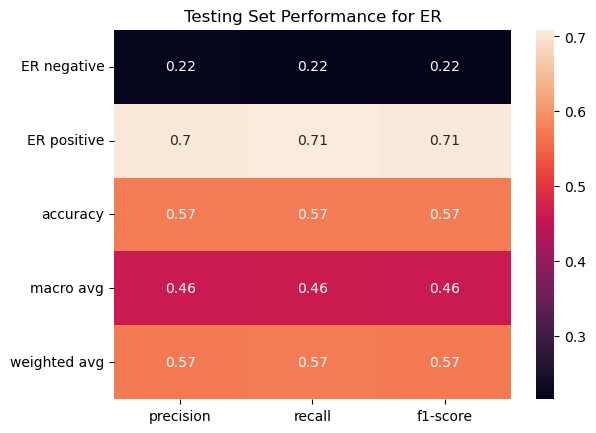

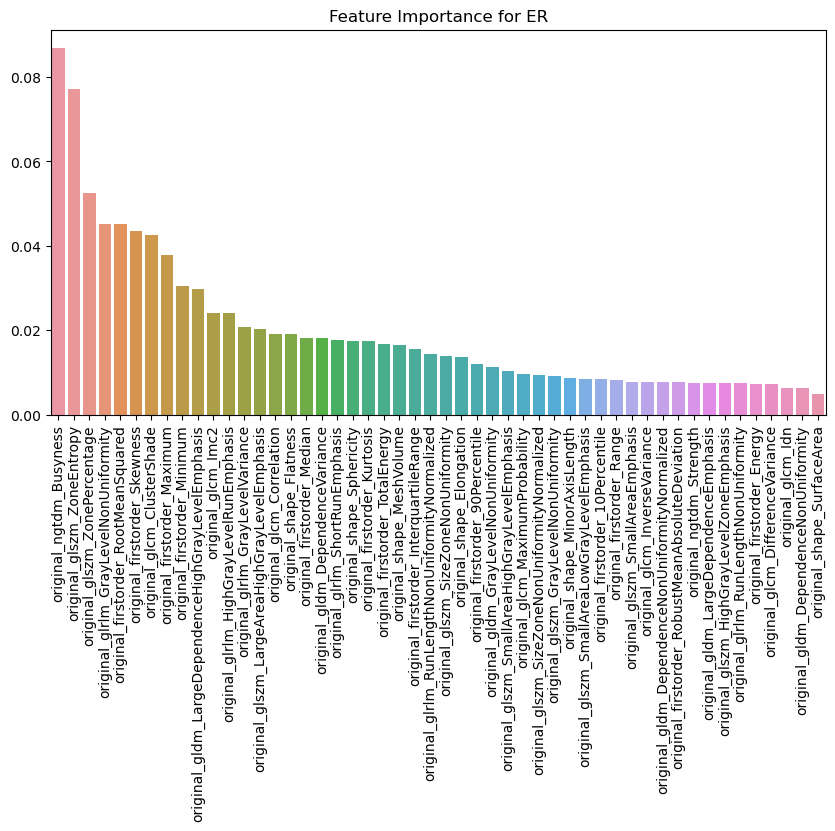

In [11]:
feature_importance_er = get_feature_importances('ER', 50, train_x, train_y, val_x, val_y, test_x, test_y)

In [12]:
feat_imp_er = pd.DataFrame(feature_importance_er, index = [0]).T.reset_index().rename(columns = {'index': 'Feature', 0:'Importance'})
feat_imp_er.to_csv("Feature Importance/ER feature importance.csv", index = False)

### PR

Training Accuracy: 1.0000, Validation Accuracy: 0.5924
Training Precision: 1.0000, Validation Precision: 0.5720
Training Recall: 1.0000, Validation Recall: 0.5924
Training F1-Score: 1.0000, Validation F1-Score: 0.5784


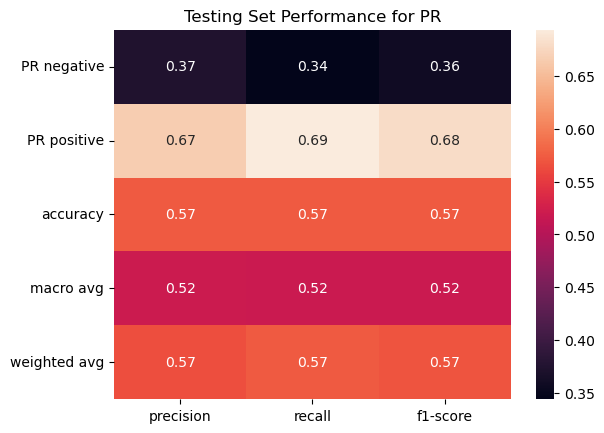

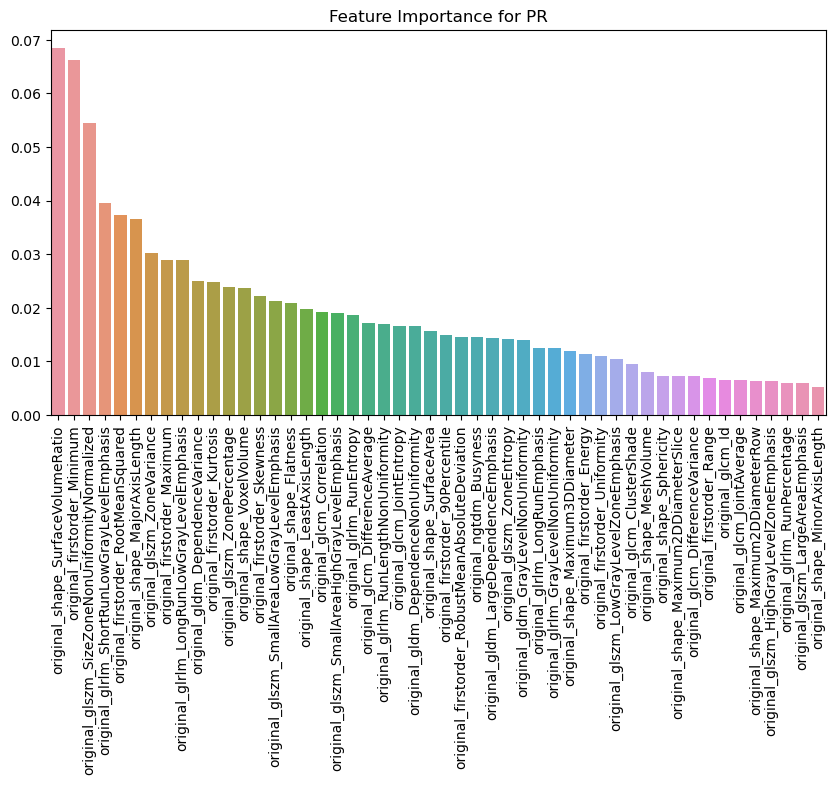

In [13]:
feature_importance_pr = get_feature_importances('PR', 50, train_x, train_y, val_x, val_y, test_x, test_y)

In [14]:
feat_imp_pr = pd.DataFrame(feature_importance_er, index = [0]).T.reset_index().rename(columns = {'index': 'Feature', 0:'Importance'})
feat_imp_pr.to_csv("Feature Importance/PR feature importance.csv", index = False)

### HER2

Training Accuracy: 1.0000, Validation Accuracy: 0.7337
Training Precision: 1.0000, Validation Precision: 0.7744
Training Recall: 1.0000, Validation Recall: 0.7337
Training F1-Score: 1.0000, Validation F1-Score: 0.7509


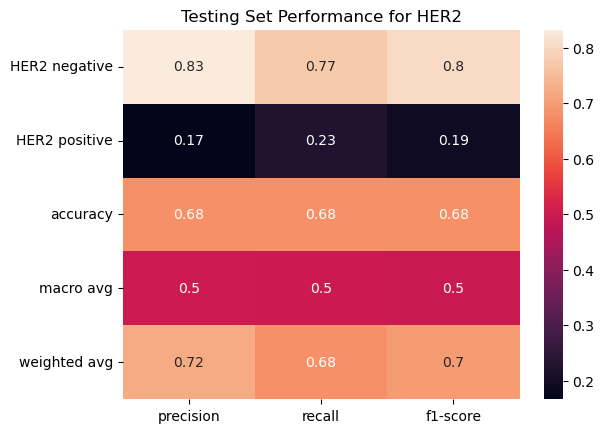

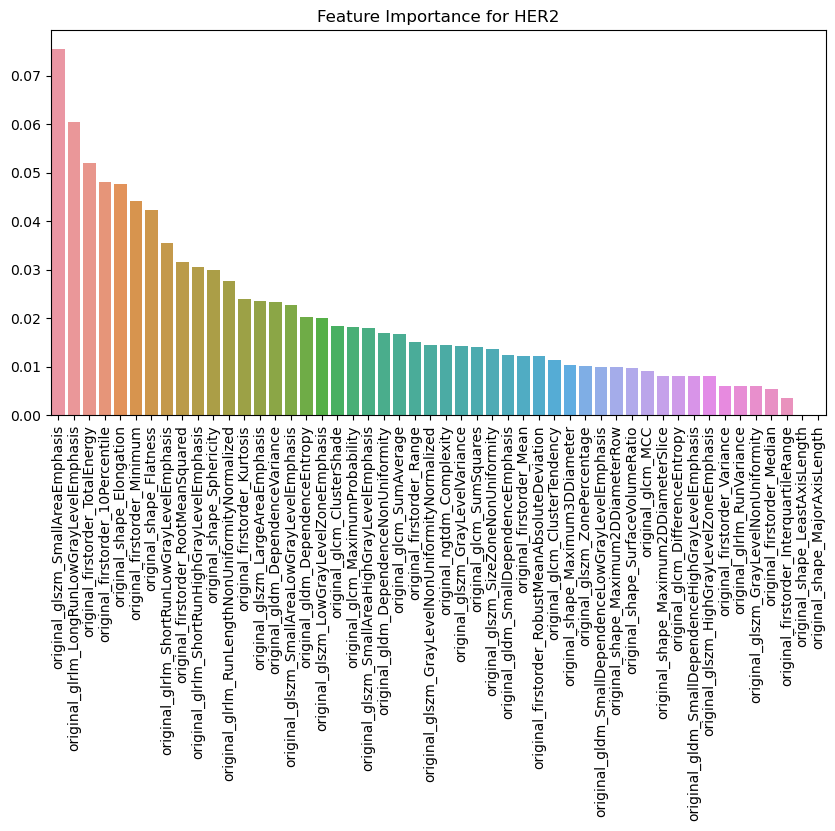

In [15]:
feature_importance_her2 = get_feature_importances('HER2', 50, train_x, train_y, val_x, val_y, test_x, test_y)

In [16]:
feat_imp_her2 = pd.DataFrame(feature_importance_er, index = [0]).T.reset_index().rename(columns = {'index': 'Feature', 0:'Importance'})
feat_imp_her2.to_csv("Feature Importance/HER2 feature importance.csv", index = False)

### Subtype

#### Trivial method: use features only

Training Accuracy: 1.0000, Validation Accuracy: 0.4946
Training Precision: 1.0000, Validation Precision: 0.5369
Training Recall: 1.0000, Validation Recall: 0.4946
Training F1-Score: 1.0000, Validation F1-Score: 0.5129


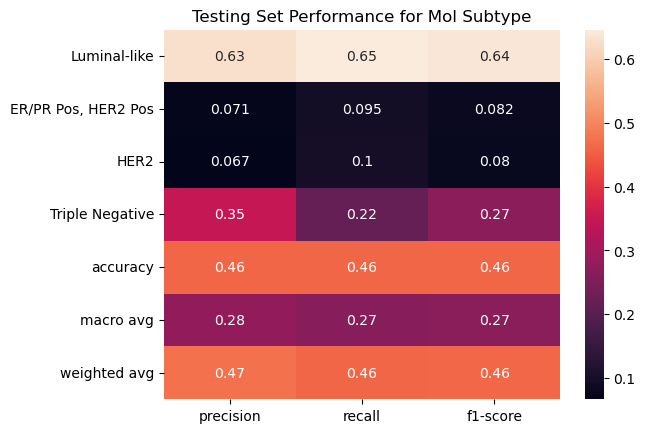

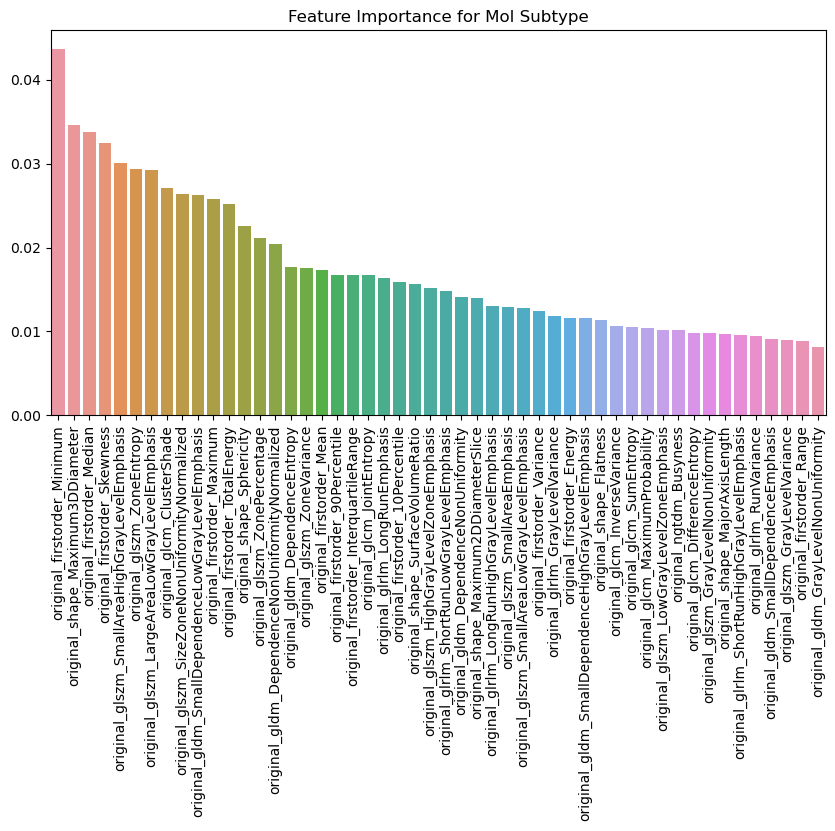

In [17]:
feature_importance_subtype = get_feature_importances('Mol Subtype', 50, train_x, train_y, val_x, val_y, test_x, test_y)

In [18]:
feature_importance_subtype = pd.DataFrame(feature_importance_subtype, index = [0]).T.reset_index().rename(columns = {'index': 'Feature', 0:'Importance'})
feature_importance_subtype.to_csv("Feature Importance/Molecular Subtype feature importance (trivial).csv", index = False)

#### Using Predicted labels